In [ ]:
import pandas as pd
from datetime import datetime
from pandas import DataFrame
from pandas import read_csv
#h=pd.read_csv("Clearness Index3.csv" )

#h1=h.drop([ 'insolation_clearness_index','temp','Min_temp','Claer_sky_ii','humidity','dew/frost_point','max_temp','wind_s','precipitation'], axis=1)
#h1.to_csv('All_sky_ii.csv',  index = None)
h1=pd.read_csv("All_sky_ii2.csv" )

number = 24
elements = 1127

thelist = [number] * elements
h1['thelist'] = thelist

Hour = ['01','02','03','04','05','06','07','08', '09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','00']

elements = 1127

Hour = [Hour] * elements

my_new_list = []
for sub_list in Hour:
    # Now go over each item of the sublist
    for item in sub_list:
        # append it to our new list
        my_new_list.append(item)
        
        out =h1.reindex(h1.index.repeat(h1['thelist']))
h1=out.drop(['thelist'], axis=1)

h1['Hour'] = my_new_list
h1["DateTime"] = (h1["date"] +" "+ h1["Hour"])
h_data=h1.drop(['date','Hour'],axis=1)


h_data['DateTime'] = pd.to_datetime(h_data['DateTime'])

h_data=h_data.set_index(h_data['DateTime'], drop=False, append=False, inplace=False, verify_integrity=False).drop('DateTime', 1)
h_data.columns=['All_Sky_Insolation_Incident']

#h_data

In [ ]:

d = pd.read_csv("load3.csv" )

d.columns = ['date' ,'01','02','03','04','05','06','07','08', '09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','00']
d.to_csv('load3.csv',  index = None)

from pandas import DataFrame

# read first line
with open("load3.csv") as myfile:
    headRow = next(myfile)

# read column names    
columns = [x.strip() for x in headRow.split(',')]

# process by pandas
data = pd.read_csv("load3.csv", names=columns[1:], skiprows=1)

stacked=data.stack()

stacked = stacked.to_frame()
stacked.columns=['Load']
s=stacked.reset_index()
s.columns=['Date','Hour','Load']
s["DateTime"] = (s["Date"] +" "+ s["Hour"])
s = s[["DateTime","Load"]]
from datetime import datetime

s['DateTime'] = pd.to_datetime(s['DateTime'])
dataset=s.set_index(s['DateTime'], drop=False, append=False, inplace=False, verify_integrity=False).drop('DateTime', 1)
#dataset

In [ ]:
df=pd.merge(dataset,h_data,on='DateTime')
df

In [ ]:
import numpy as np

train_size = int(len(df) * 0.6)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

test_size = int(len(test) * 0.5)
val_size = len(test) - test_size
val, test = test.iloc[0:test_size], test.iloc[test_size:len(test)]
print(len(test), len(val))

In [ ]:
train,val,test

In [ ]:
from sklearn.preprocessing import MinMaxScaler

f_columns = ['All_Sky_Insolation_Incident']

f_transformer = MinMaxScaler()
t_transformer = MinMaxScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
t_transformer = t_transformer.fit(train[['Load']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['Load'] = t_transformer.transform(train[['Load']])

val.loc[:, f_columns] = f_transformer.transform(val[f_columns].to_numpy())
val['Load'] = t_transformer.transform(val[['Load']])


test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['Load'] = t_transformer.transform(test[['Load']])

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)



In [ ]:
import numpy as np

time_steps = 24

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.Load, time_steps)

X_validate, y_validate = create_dataset(val, val.Load, time_steps)

X_test, y_test = create_dataset(test, test.Load, time_steps)


print(X_train.shape, y_train.shape,X_validate.shape, y_validate.shape,X_test.shape, y_test.shape)

In [ ]:
!pip install keras_tuner

In [ ]:
import pandas as pd
import math
import keras
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import save_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import keras_tuner
#from kerastuner.tuners import RandomSearch
#from kerastuner.engine.hyperparameters import HyperParameters
from pickle import dump,load
from keras_tuner import RandomSearch
from keras_tuner import HyperModel
from keras_tuner import HyperParameters
import warnings
warnings.simplefilter("ignore", UserWarning)
from tensorflow.keras import layers


In [15]:
from tensorflow.keras.callbacks import EarlyStopping
custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    min_delta=0.001, #10^-3
    mode='auto'
)

In [ ]:
import tensorflow as tf
def build_model(hp):
    model = keras.Sequential()
    
    model.add(layers.LSTM(units=hp.Int('units_1' ,
                                            min_value=180,
                                            max_value=460,
                                            step=12),
                          input_shape=(X_train.shape[1], X_train.shape[2])
                             ,return_sequences=True))
    
    model.add(layers.LSTM(units=hp.Int('units_2' ,
                                            min_value=20,
                                            max_value=460,
                                            step=12)
                             ,return_sequences=True))
    
    model.add(layers.LSTM(units=hp.Int('units_3' ,
                                            min_value=276,
                                            max_value=512,
                                            step=12)
                             ,return_sequences=True))
    
    model.add(layers.LSTM(units=hp.Int('units_4' ,
                                            min_value=148,
                                            max_value=430,
                                            step=12)
                             ,return_sequences=True))
    
    model.add(layers.LSTM(units=hp.Int('Last_units' ,
                                            min_value=276,
                                            max_value=380,
                                            step=12) ))
   
    
    #if hp.Boolean("dropout"):
      # model.add(layers.Dropout(rate=0.25)) 

    model.add(layers.Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam( ),
        loss='mean_squared_error',
        metrics=['mse'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=3,
    executions_per_trial=1,
    overwrite=True
)

In [ ]:
tuner.search_space_summary()

In [16]:
tuner.search(
        x=X_train,
        y= y_train,
        epochs=200,
        batch_size=32,
        validation_data=(X_validate, y_validate),
        callbacks=[custom_early_stopping]
)

Trial 3 Complete [01h 12m 20s]
val_mse: 0.0004686340398620814

Best val_mse So Far: 0.0004686340398620814
Total elapsed time: 02h 52m 16s
INFO:tensorflow:Oracle triggered exit


In [18]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_mse', direction='min')
Trial summary
Hyperparameters:
units_1: 192
units_2: 440
units_3: 492
units_4: 268
Last_units: 276
Score: 0.0004686340398620814
Trial summary
Hyperparameters:
units_1: 216
units_2: 128
units_3: 300
units_4: 268
Last_units: 276
Score: 0.0004714150563813746
Trial summary
Hyperparameters:
units_1: 240
units_2: 404
units_3: 372
units_4: 352
Last_units: 324
Score: 0.0005230988026596606


In [19]:
model=tuner.get_best_models()[0]
history=model.fit(X_train,y_train, epochs=50,batch_size=32, validation_data=(X_validate, y_validate))

Epoch 1/50
507/507 [==============================] - 396s 767ms/step - loss: 3.6817e-04 - mse: 3.6817e-04 - val_loss: 4.7673e-04 - val_mse: 4.7673e-04
Epoch 2/50
507/507 [==============================] - 387s 763ms/step - loss: 3.8381e-04 - mse: 3.8381e-04 - val_loss: 6.2664e-04 - val_mse: 6.2664e-04
Epoch 3/50
507/507 [==============================] - 386s 762ms/step - loss: 3.4255e-04 - mse: 3.4255e-04 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 4/50
507/507 [==============================] - 387s 764ms/step - loss: 3.8667e-04 - mse: 3.8667e-04 - val_loss: 5.2218e-04 - val_mse: 5.2218e-04
Epoch 5/50
507/507 [==============================] - 387s 763ms/step - loss: 3.2107e-04 - mse: 3.2107e-04 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 6/50
507/507 [==============================] - 389s 767ms/step - loss: 2.9176e-04 - mse: 2.9176e-04 - val_loss: 3.7076e-04 - val_mse: 3.7076e-04
Epoch 7/50
507/507 [==============================] - 388s 766ms/step - loss: 2.3564e-04 - mse: 2.3564e-

In [20]:
val_mse_per_epoch = history.history['val_mse']
best_epoch = val_mse_per_epoch.index(min(val_mse_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Best epoch: 31


In [21]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 192)           149760    
                                                                 
 lstm_1 (LSTM)               (None, 24, 440)           1114080   
                                                                 
 lstm_2 (LSTM)               (None, 24, 492)           1836144   
                                                                 
 lstm_3 (LSTM)               (None, 24, 268)           815792    
                                                                 
 lstm_4 (LSTM)               (None, 276)               601680    
                                                                 
 dense (Dense)               (None, 1)                 277       
                                                                 
Total params: 4,517,733
Trainable params: 4,517,733
Non-

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


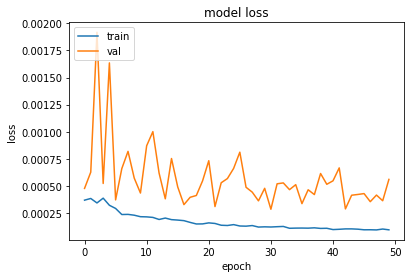

In [22]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')



In [23]:
from math import sqrt
from sklearn.metrics import mean_squared_error


y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_validate)


#inverse
y_train_inv = t_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = t_transformer.inverse_transform(y_test.reshape((len(y_test), 1)))
y_pred_inv = t_transformer.inverse_transform(y_pred)

y_validate_inv = t_transformer.inverse_transform(y_validate.reshape(-1, 1))

y_pred_train_inv = t_transformer.inverse_transform(y_pred_train)
y_pred_val_inv = t_transformer.inverse_transform(y_pred_val)

In [24]:
# calculate RMSE
rmse = sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 32.729


In [25]:
actual_test=y_test_inv
Nrmse_test=rmse /(actual_test.max() - actual_test.min())

print(Nrmse_test)

0.013070736146573054


In [26]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test_inv, y_pred_inv)

0.011860345284108547

In [27]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test_inv, y_pred_inv)

24.13813452538265

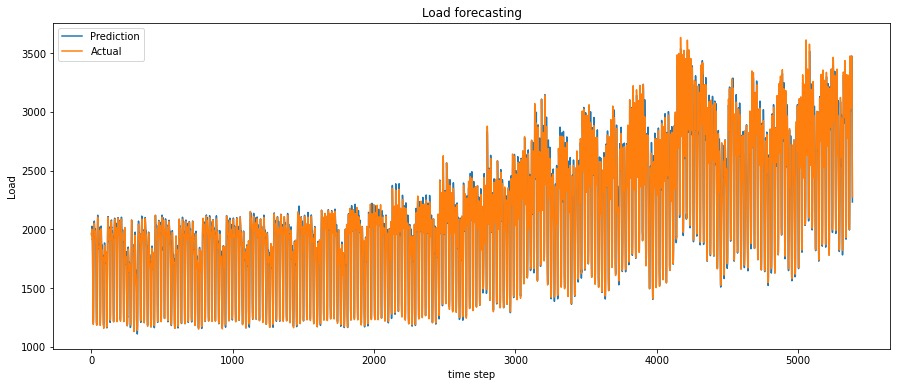

In [28]:
plt.figure(figsize=(15,6))
plt.plot(y_pred_inv, label="Prediction" )
plt.plot(y_test_inv, label="Actual")
plt.legend()
plt.ylabel('Load')
plt.xlabel('time step' )
#plt.title ("Russell 2000 Adj close Price prediction- with MAE {:10.4f}".format(mae))
plt.title ('Load forecasting')
plt.show()

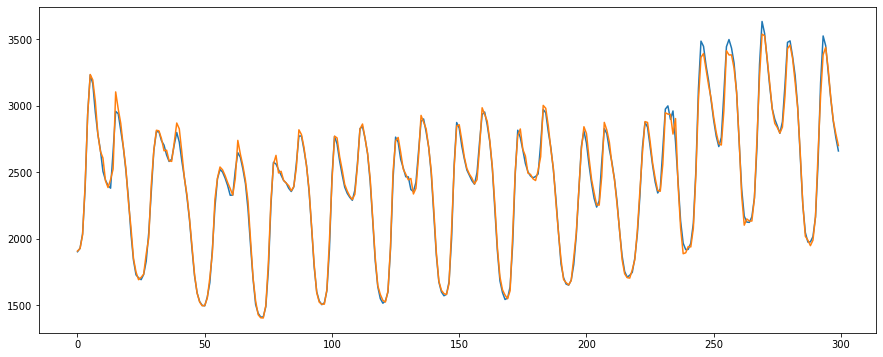

In [29]:
#zoom in spikes


plt.figure(figsize=(15,6))

plt.plot(y_test_inv[3900:4200])
plt.plot(y_pred_inv[3900:4200])

plt.show()

In [30]:
test_2=test.reset_index()
new_test = test_2.filter(['DateTime'])
#new_test.loc[24:, :]

train_2=train.reset_index()
new_train = train_2.filter(['DateTime'])
#new_train.loc[24:, :]

val_2=val.reset_index()
new_val = val_2.filter(['DateTime'])
#new_val.loc[24:, :]


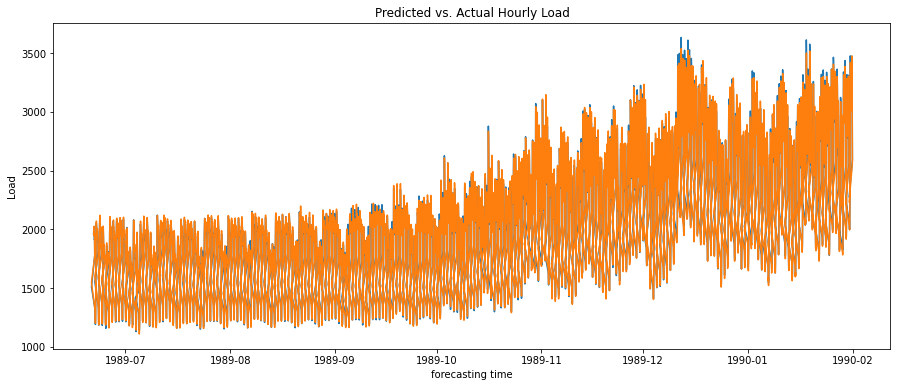

In [31]:
#plot with dates

import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))

# Plot all predictions
#inversetransform, =plt.plot(scaler.inverse_transform(df))
trainpred, =plt.plot(new_test.loc[24:, :],y_test_inv)
valpred, =plt.plot(new_test.loc[24:, :],y_pred_inv)
plt.xlabel('forecasting time')
plt.ylabel('Load')
plt.title("Predicted vs. Actual Hourly Load")
plt.show()

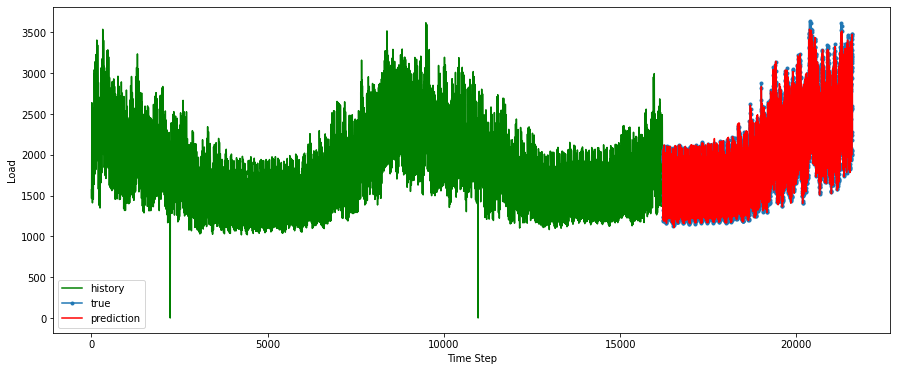

In [32]:
#whole data plot

plt.figure(figsize=(15,6))

plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Load')
plt.xlabel('Time Step')
plt.legend()
plt.show();

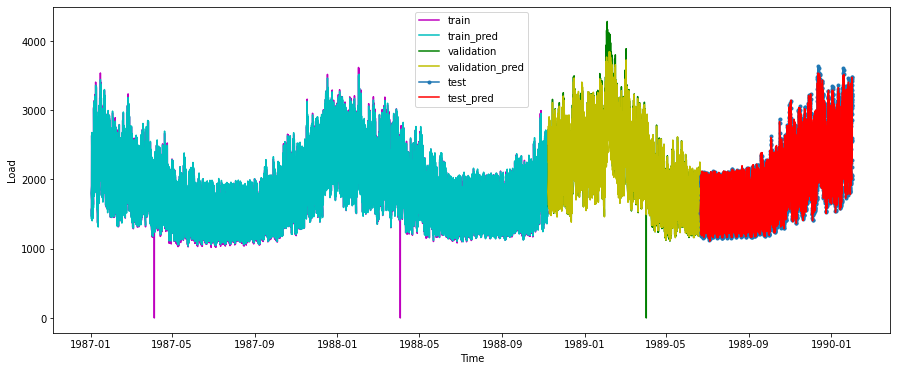

In [33]:
#whole data plot wiyh pred


plt.figure(figsize=(15,6))

plt.plot(new_train.loc[24:, :], y_train_inv.flatten(), 'm', label="train")
plt.plot(new_train.loc[24:, :], y_pred_train_inv.flatten(), 'c', label="train_pred")

plt.plot(new_val.loc[24:, :], y_validate_inv.flatten(), 'g', label="validation")
plt.plot(new_val.loc[24:, :], y_pred_val_inv.flatten(), 'y', label="validation_pred")

plt.plot(new_test.loc[24:, :], y_test_inv.flatten(), marker='.', label="test")
plt.plot(new_test.loc[24:, :], y_pred_inv.flatten(), 'r', label="test_pred")
plt.ylabel('Load')
plt.xlabel('Time')
plt.legend()
plt.show();

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error


###### ???????#####
y_train_inv = t_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = t_transformer.inverse_transform(y_test.reshape((len(y_test), 1)))
y_pred_inv = t_transformer.inverse_transform(y_pred)

In [ ]:
# calculate RMSE
rmse = sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 49.396


In [ ]:
actual_test=y_test_inv
Nrmse_test=rmse /(actual_test.max() - actual_test.min())

print(Nrmse_test)

0.019726662295672357


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test_inv, y_pred_inv)

0.01780175252219751

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test_inv, y_pred_inv)

36.75902923685974